# Mixed States Reconstruction (Infidelity as loss)

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [2]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation (Haar Distribution)

In [3]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [5]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [6]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.uniform(0,1) * bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [7]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [8]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [9]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) **2
   return infidelity

## Noise Model

In [10]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [11]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [12]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [13]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [14]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [25]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [26]:
#GENERATE DATA
data = generate_Haar_data(1, 10)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

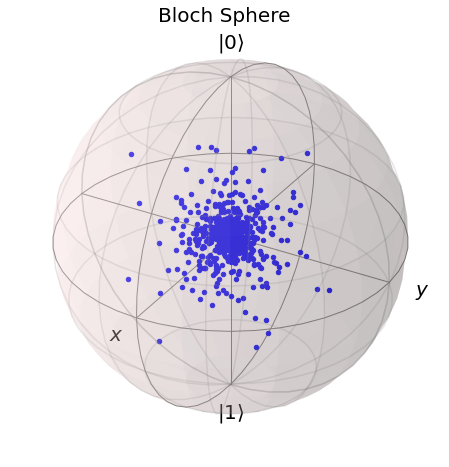

In [27]:
#VISUALIZE DATA ON BLOCH SPHERE
Bloch_sphere(bloch_vectors_noise_free)

In [28]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [29]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

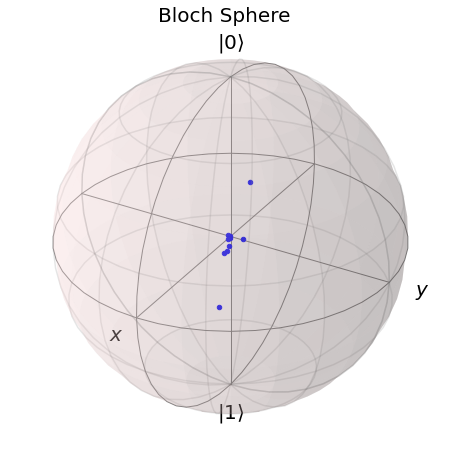

In [30]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
Bloch_sphere(bloch_vectors_with_noise)

In [31]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:8], bloch_vectors_with_noise[8:9], bloch_vectors_with_noise[9:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:8], bloch_vectors_noise_free[8:9], bloch_vectors_noise_free[9:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [32]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [33]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a/b
  return output

In [36]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(128, activation='relu')(input_layer1)
x = Dense(64, activation='relu')(x)
x = Dense(units='3', name='vector')(x)
model_1 = Model(inputs = input_layer1, outputs = x)


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 128)          512         ['input_3[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 64)           8256        ['dense_3[0][0]']                
                                                                                                  
 vector (Dense)                 (None, 3)            195         ['dense_4[0][0]']                
                                                                                            

In [37]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.0001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=8, epochs=10)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0013 - val_loss: 4.7403e-04
Epoch 2/10
1/1 [==============================] - 0s 90ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 3/10
1/1 [==============================] - 0s 82ms/step - loss: 0.0013 - val_loss: 0.0497
Epoch 4/10
1/1 [==============================] - 0s 93ms/step - loss: 0.0013 - val_loss: 0.1844
Epoch 5/10
1/1 [==============================] - 0s 102ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 6/10
1/1 [==============================] - 0s 96ms/step - loss: 0.0013 - val_loss: -0.2240
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.0014 - val_loss: -0.5173
Epoch 8/10
1/1 [==============================] - 0s 95ms/step - loss: 0.0014 - val_loss: -0.8710
Epoch 9/10
1/1 [==============================] - 0s 78ms/step - loss: 0.0016 - val_loss: -1.2940
Epoch 10/10
1/1 [==============================] - 0s 78ms/step - loss: 0.0017 - val_loss: -1.8204


In [38]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

ValueError: Data cardinality is ambiguous:
  x sizes: 1, 991
  y sizes: 991
Make sure all arrays contain the same number of samples.

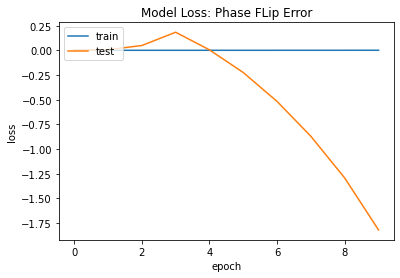

In [39]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()